# Wiener Filter Implementation in TensorFlow

To implement Wiener Filter functions, we are going to mimic its implementation in Scikit Image (see skimage.restoration.wiener) and in Tikhonet (see https://github.com/CosmoStat/ShapeDeconv/blob/master/python/DeepDeconv/utils/deconv_utils_FCS.py).

## Implementation in skimage:

In [1]:
from skimage.restoration import uft
import numpy as np

def wiener(image, psf, balance, reg=None, is_real=True, clip=True):
    if reg is None:
        reg, _ = uft.laplacian(image.ndim, image.shape, is_real=is_real)
    if not np.iscomplexobj(reg):
        reg = uft.ir2tf(reg, image.shape, is_real=is_real)

    if psf.shape != reg.shape:
        trans_func = uft.ir2tf(psf, image.shape, is_real=is_real)
    else:
        trans_func = psf

    wiener_filter = np.conj(trans_func) / (np.abs(trans_func) ** 2 +
                                           balance * np.abs(reg) ** 2)
    if is_real:
        deconv = uft.uirfft2(wiener_filter * uft.urfft2(image),
                             shape=image.shape)
    else:
        deconv = uft.uifft2(wiener_filter * uft.ufft2(image))

    if clip:
        deconv[deconv > 1] = 1
        deconv[deconv < -1] = -1

    return deconv

#USAGE CASE OF tikhonov:
#deconv_img = tikhonov(noisy_img, psfs, 1./SNR_list)
def tikhonov(X, psf, tau):
    if len(X.shape) == 2:
        return(wiener(X, psf, tau))
    tikho_list = []
    for i in range(len(X)):
        deconvolved = wiener(X[i], psf[i],tau[i])
        tikho_list.append(deconvolved)
    return np.asarray(tikho_list)

## Minimal Required Parts of the `wiener` function:

In [2]:
def wiener(image, psf, balance):
    trans_func = uft.ir2tf(psf, image.shape)
    wiener_filter = np.conj(trans_func) / (np.abs(trans_func) ** 2 + balance)
    deconv = uft.uirfft2(wiener_filter * uft.urfft2(image),
                        shape=image.shape)
    deconv[deconv > 1] = 1
    deconv[deconv < -1] = -1

    return deconv

## TensorFlow Implementation

In [3]:
import tensorflow as tf

def wiener_tf(image, psf, balance):
    trans_func = tf.signal.rfft2d(tf.signal.ifftshift(psf))
    wiener_filter = tf.math.conj(trans_func) / (tf.dtypes.cast(tf.math.abs(trans_func),'complex64') ** 2 + balance)
    deconv = tf.signal.irfft2d(wiener_filter * tf.signal.rfft2d(image),fft_length=image.shape)
    deconv = tf.keras.backend.clip(deconv, -1, 1)

    return deconv

def tikhonov_tf(img, psf, tau):
    if len(img.shape) == 2:
        return(wiener_tf(img, psf, tau))
    tikho_list = []
    for i in range(img.shape[0]):
        deconvolved = wiener_tf(img[i], psf[i], tau[i])
        tikho_list += [deconvolved]
    return tikho_list

## Basic Test

Text(0.5, 1.0, 'psf')

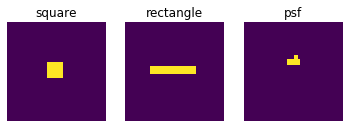

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

# create mock data
images = np.zeros((2,128,128))
psf = np.zeros((128,128))
# create square and rectangle images
size = 10
# square image
images[0,62-size:62+size,62-size:62+size] = 1
# rectangle image
images[1,62-5:62+5,62-3*size:62+3*size] = 1
# psf image
psf[43:48,65:70] = 1
psf[48:55,55:72] = 1

# show images
plt.figure(1)
plt.subplot(131)
plt.imshow(images[0])
plt.axis('off')
plt.title('square')
plt.subplot(132)
plt.imshow(images[1])
plt.axis('off')
plt.title('rectangle')
plt.subplot(133)
plt.imshow(psf)
plt.axis('off')
plt.title('psf')


Text(0.5, 1.0, 'deconvolved rectangle')

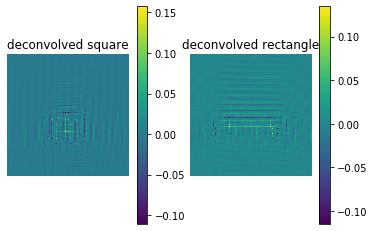

In [5]:
# deconvolved numpy images
tau = [1,1]
deconv_images_np = tikhonov(images, [psf,psf], tau)

# plot deconvolved images
plt.figure(2)
plt.subplot(121)
plt.imshow(deconv_images_np[0])
plt.colorbar()
plt.axis('off')
plt.title('deconvolved square')
plt.subplot(122)
plt.imshow(deconv_images_np[1])
plt.colorbar()
plt.axis('off')
plt.title('deconvolved rectangle')

Text(0.5, 1.0, 'deconvolved TF rectangle')

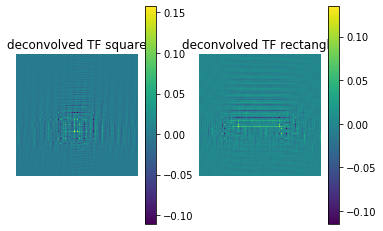

In [6]:
# convert arrays to tensors
images_tf = tf.convert_to_tensor(images,dtype='float32')
psf_tf = tf.convert_to_tensor(psf,dtype='float32')

# deconvolved tf images
deconv_images = tikhonov_tf(images_tf, [psf_tf,psf_tf], tau)

dec_1 = tf.keras.backend.eval(deconv_images[0])
dec_2 = tf.keras.backend.eval(deconv_images[1])
# plot deconvolved tensorflow images
plt.figure(3)
plt.subplot(121)
plt.imshow(dec_1)
plt.colorbar()
plt.axis('off')
plt.title('deconvolved TF square')
plt.subplot(122)
plt.imshow(dec_2)
plt.colorbar()
plt.axis('off')
plt.title('deconvolved TF rectangle')

## Compare Test Results

Text(0.5, 1.0, 'differences 2')

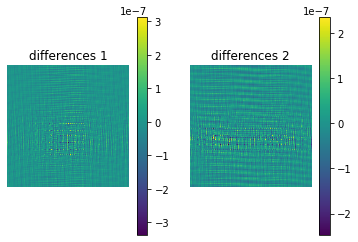

In [7]:
# plot the difference of the deconvolved images
plt.figure(4)
plt.subplot(121)
plt.imshow(dec_1-deconv_images_np[0])
plt.colorbar()
plt.axis('off')
plt.title('differences 1')
plt.subplot(122)
plt.imshow(dec_2-deconv_images_np[1])
plt.colorbar()
plt.axis('off')
plt.title('differences 2')

## Fourier Transform Tensorflow Test

Text(0.5, 1.0, 'square uft reconstruction')

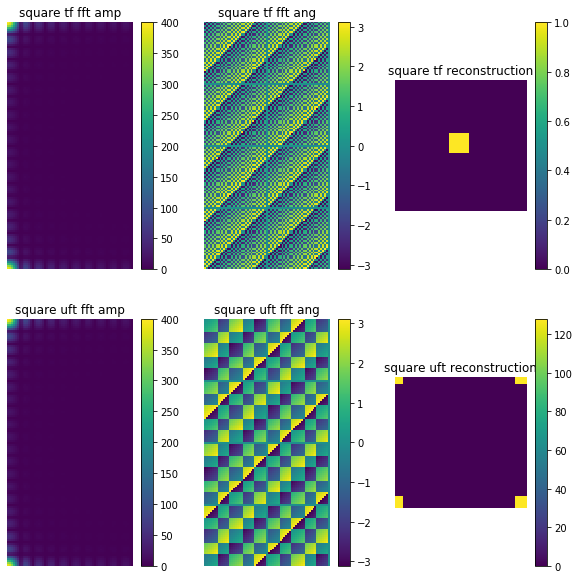

In [8]:
square_fft = tf.signal.rfft2d(images_tf[0])
square_ifft = tf.signal.irfft2d(square_fft)
fft_array = tf.keras.backend.eval(square_fft)
ifft_array = tf.keras.backend.eval(tf.dtypes.cast(square_ifft,'float32'))

square_fft_np = uft.ir2tf(images[0], psf.shape)#np.fft.fft2(images[0])#
square_ifft_np = uft.uirfft2(square_fft_np, psf.shape)

# plot the real fft and ifft of the square
plt.figure(5, figsize=[10,10])
plt.subplot(231)
plt.imshow(np.abs(fft_array))
plt.colorbar()
plt.axis('off')
plt.title('square tf fft amp')
plt.subplot(232)
plt.imshow(np.angle(fft_array))
plt.colorbar()
plt.axis('off')
plt.title('square tf fft ang')
plt.subplot(233)
plt.imshow(ifft_array)
plt.colorbar()
plt.axis('off')
plt.title('square tf reconstruction')

plt.subplot(234)
plt.imshow(np.abs(square_fft_np))
plt.colorbar()
plt.axis('off')
plt.title('square uft fft amp')
plt.subplot(235)
plt.imshow(np.angle(square_fft_np))
plt.colorbar()
plt.axis('off')
plt.title('square uft fft ang')
plt.subplot(236)
plt.imshow(np.real(square_ifft_np))
plt.colorbar()
plt.axis('off')
plt.title('square uft reconstruction')


## Wiener Filter Test

In [9]:
trans_func = uft.ir2tf(psf, psf.shape)
wiener_filter = np.conj(trans_func) / (np.abs(trans_func) ** 2 + 1)
wiener_recons = uft.uirfft2(wiener_filter,shape=psf.shape)

In [10]:
trans_func = tf.signal.rfft2d(psf_tf)
wiener_filter_tf = tf.math.conj(trans_func) / (tf.dtypes.cast(tf.square(tf.math.abs(trans_func)),'complex64') + 1)
wiener_filter_tf_np = tf.keras.backend.eval(wiener_filter_tf)
wiener_recons_tf = tf.signal.irfft2d(wiener_filter_tf,fft_length=psf_tf.shape)
wiener_recons_tf_np = tf.keras.backend.eval(wiener_recons_tf)

Text(0.5, 1.0, 'tensorflow filter recons')

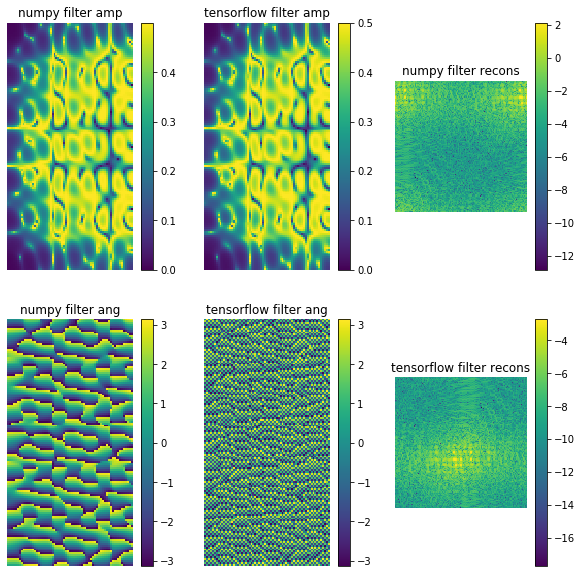

In [11]:
# plot the difference of the deconvolved images
plt.figure(6,figsize=[10,10])
plt.subplot(231)
plt.imshow(np.abs(wiener_filter))
plt.colorbar()
plt.axis('off')
plt.title('numpy filter amp')
plt.subplot(232)
plt.imshow(np.abs(wiener_filter_tf_np))
plt.colorbar()
plt.axis('off')
plt.title('tensorflow filter amp')
plt.subplot(233)
plt.imshow(np.log(np.abs(wiener_recons)))
plt.colorbar()
plt.axis('off')
plt.title('numpy filter recons')
plt.subplot(234)
plt.imshow(np.angle(wiener_filter))
plt.colorbar()
plt.axis('off')
plt.title('numpy filter ang')
plt.subplot(235)
plt.imshow(np.angle(wiener_filter_tf_np))
plt.colorbar()
plt.axis('off')
plt.title('tensorflow filter ang')
plt.subplot(236)
plt.imshow(np.log(np.abs(wiener_recons_tf_np)))
plt.colorbar()
plt.axis('off')
plt.title('tensorflow filter recons')

In [12]:
%matplotlib inline
import sys

# Add library path to PYTHONPATH
lib_path = '/gpfswork/rech/xdy/uze68md/GitHub/'
path_alphatransform = lib_path+'alpha-transform'
path_score = lib_path+'score'
sys.path.insert(0, path_alphatransform)
sys.path.insert(0, path_score)

# Libraries
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import fft
import cadmos_lib as cl
import tensorflow as tf
import galsim
from galsim import Image
import galsim.hsm
import galflow as gf
from galaxy2galaxy import problems

In [13]:
# Functions

def ir2tf_simplifie(imp_resp, shape):
    

    dim = 2
    # Zero padding and fill
    irpadded = np.zeros(shape)
    irpadded[tuple([slice(0, s) for s in imp_resp.shape])] = imp_resp
    # Roll for zero convention of the fft to avoid the phase
    # problem. Work with odd and even size.
    for axis, axis_size in enumerate(imp_resp.shape):

        irpadded = np.roll(irpadded,
                           shift=-int(np.floor(axis_size / 2)),
                           axis=axis)

    return fft.rfftn(irpadded, axes=range(-dim, 0))

def laplacian_simplifie(shape):
    
    impr = np.zeros([3,3])
    for dim in range(2):
        idx = tuple([slice(1, 2)] * dim +
                    [slice(None)] +
                    [slice(1, 2)] * (1 - dim))
        impr[idx] = np.array([-1.0,
                              0.0,
                              -1.0]).reshape([-1 if i == dim else 1
                                              for i in range(2)])
    impr[(slice(1, 2), ) * 2] = 4.0
    return ir2tf_simplifie(impr, shape), impr

def laplacian_tf(shape):
    return tf.convert_to_tensor(laplacian_simplifie(shape)[0])

def wiener_tf(image, psf, balance):
    reg = laplacian_tf(image.shape)
    if psf.shape != reg.shape:
        trans_func = tf.signal.rfft2d(tf.signal.ifftshift(tf.cast(psf, 'float32')))
    else:
        trans_func = psf
    
    arg1 = tf.cast(tf.math.conj(trans_func), 'complex64')
    arg2 = tf.dtypes.cast(tf.math.abs(trans_func),'complex64') ** 2
    arg3 = balance * tf.dtypes.cast(tf.math.abs(laplacian_tf(image.shape)), 'complex64')**2
    wiener_filter = arg1 / (arg2 + arg3)
    
    #deconv = tf.signal.irfft2d(wiener_filter * tf.signal.rfft2d(tf.cast(image, 'float32')))
    wiener_applied = wiener_filter * tf.signal.rfft2d(tf.cast(image, 'float32'))
    
    #deconv = tf.keras.backend.clip(deconv, -1, 1)
    
    return wiener_applied, trans_func

def pre_proc_unet(dico):
    r"""Preprocess the data and apply the Tikhonov filter on the input galaxy images.

    This function takes the dictionnary of galaxy images and PSF for the input and
    the target and returns a list containing 2 arrays: an array of galaxy images that
    are the output of the Tikhonov filter and an array of target galaxy images.

    Parameters
    ----------
    dico : dictionnary
        Array_like means all those objects -- lists, nested lists, etc. --
        that can be converted to an array.  We can also refer to
        variables like `var1`.

    Returns
    -------
    list
        list containing 2 arrays: an array of galaxy images that are the output of the
        Tikhonov filter and an array of target galaxy images.
    
    Example
    -------
    These are written in doctest format, and should illustrate how to
    use the function.

    >>> from galaxy2galaxy import problems # to list avaible problems run problems.available()
    >>> problem128 = problems.problem('attrs2img_cosmos_hst2euclide')
    >>> dset = problem128.dataset(Modes.TRAIN, data_dir='attrs2img_cosmos_hst2euclide')
    >>> dset = dset.map(pre_proc_unet)
    """
    x_interpolant=tf.image.ResizeMethod.BICUBIC
    # First, we interpolate the image on a finer grid
    interp_factor = 2
    Nx = 64
    Ny = 64
    dico['inputs_cfht'] = tf.image.resize(dico['inputs'],
                    [Nx*interp_factor,
                    Ny*interp_factor],
                    method=x_interpolant)
    # Since we lower the resolution of the image, we also scale the flux
    # accordingly
    dico['inputs_cfht'] = dico['inputs_cfht'] / interp_factor**2
    
    balance = 10**(-2.16)  #best after grid search
    dico['psf_inputs'] = dico['psf_cfht']
    dico['inputs_tikho'], dico['psf_cfht'] = wiener_tf(dico['inputs_cfht'][...,0], dico['psf_cfht'][...,0], balance)
    dico['inputs_tikho'] = tf.expand_dims(dico['inputs_tikho'], axis=0)
    dico['psf_cfht'] = tf.expand_dims(tf.cast(dico['psf_cfht'], 'complex64'), axis=0)
    dico['inputs_tikho'] = gf.kconvolve(dico['inputs_tikho'], dico['psf_cfht'],zero_padding_factor=1,interp_factor=interp_factor)
    dico['inputs_tikho'] = dico['inputs_tikho'][0,...]
    
    return dico

In [14]:
# Let's create an instance of the hsc_problem
Modes = tf.estimator.ModeKeys
problem128 = problems.problem('attrs2img_cosmos_cfht2hst')
dset = problem128.dataset(Modes.EVAL, data_dir='/gpfswork/rech/xdy/uze68md/data/attrs2img_cosmos_cfht2hst/')
dset = dset.repeat()
#dset = dset.map(pre_proc_unet)

n_batch = 128

dset = dset.batch(n_batch)


INFO:tensorflow:Reading data files from /gpfswork/rech/xdy/uze68md/data/attrs2img_cosmos_cfht2hst/attrs2img_cosmos_cfht2hst-dev*
INFO:tensorflow:partition: 0 num_data_files: 3

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [15]:
# Build an iterator over the dataset
iterator = dset.make_one_shot_iterator().get_next()
sess = tf.Session()

# Initialize batch
batch = sess.run(iterator)

Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.


In [16]:
batch.keys()

dict_keys(['flux_radius', 'inputs', 'mag_auto', 'ps_cfht', 'ps_hst', 'psf_cfht', 'psf_hst', 'targets', 'attributes'])

In [22]:
batch['psf_cfht'].shape

(128, 128, 65, 1)

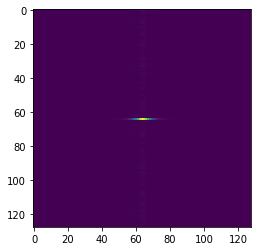

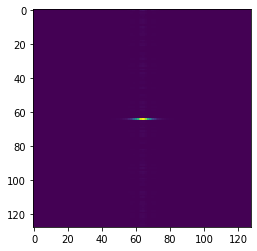

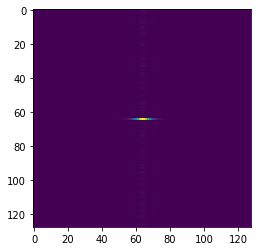

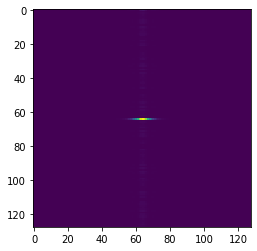

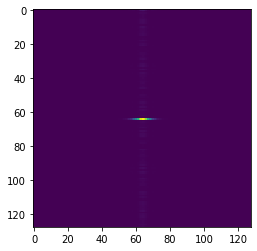

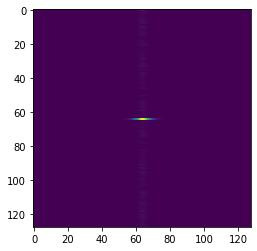

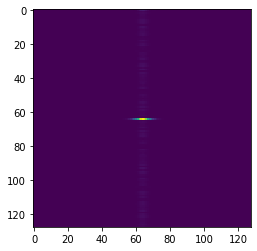

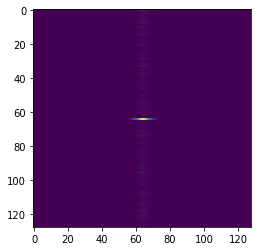

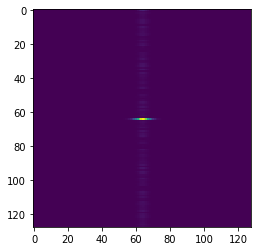

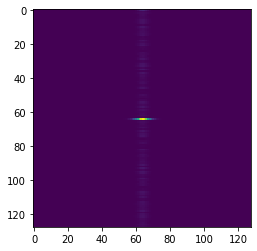

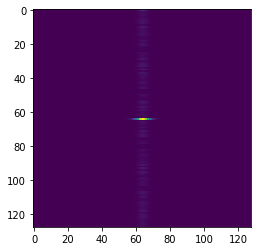

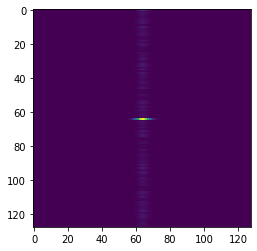

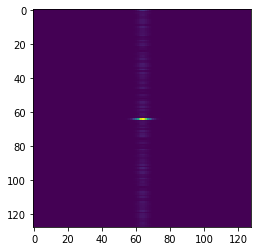

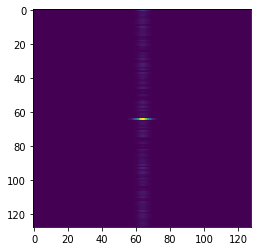

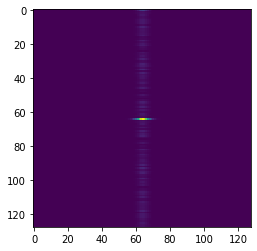

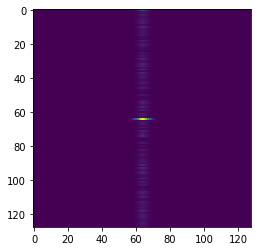

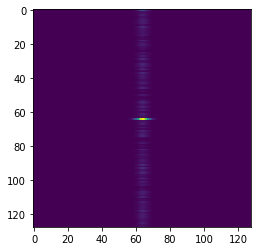

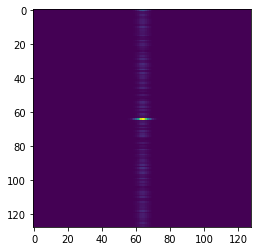

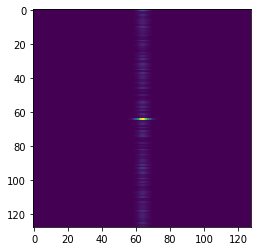

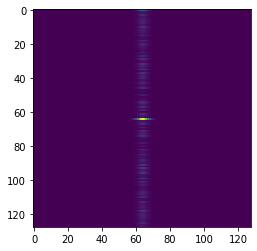

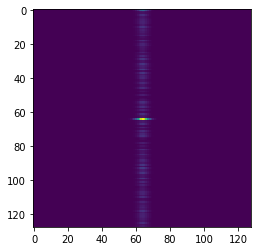

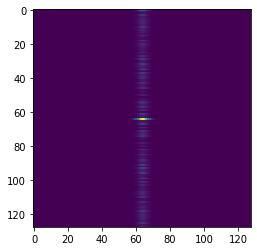

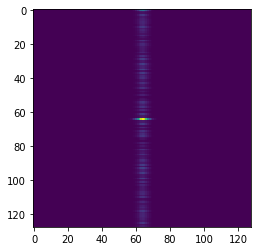

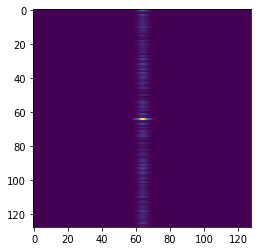

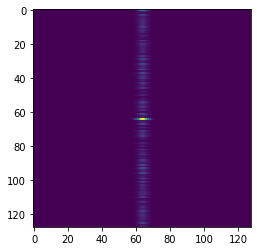

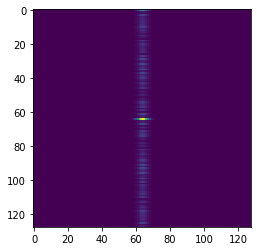

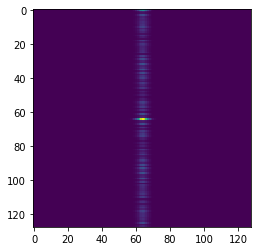

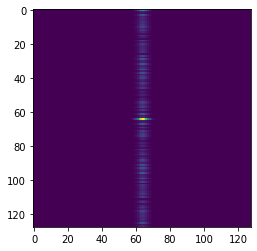

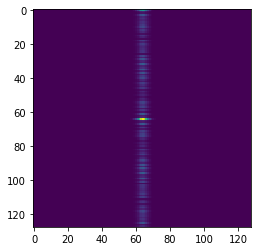

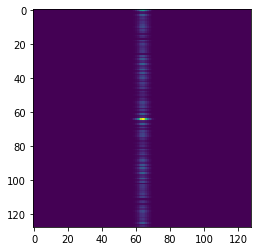

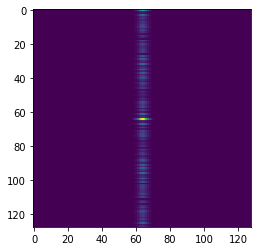

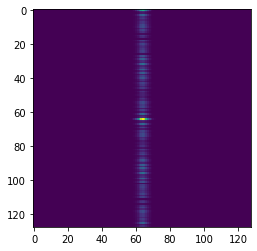

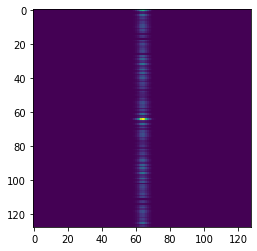

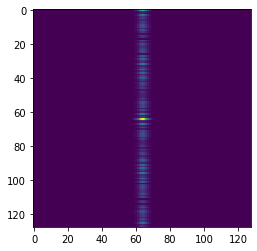

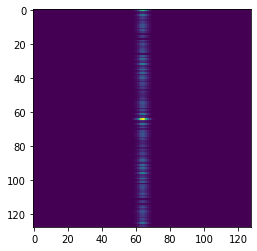

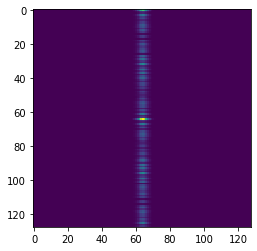

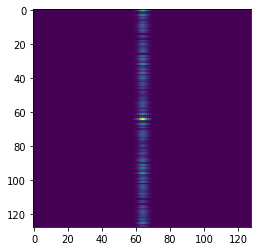

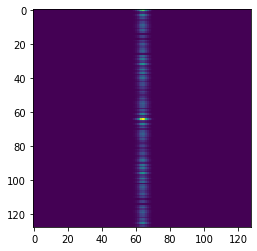

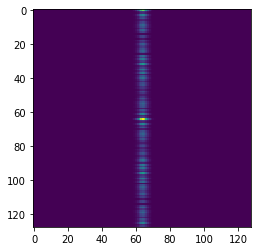

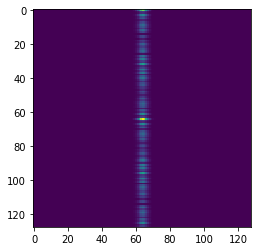

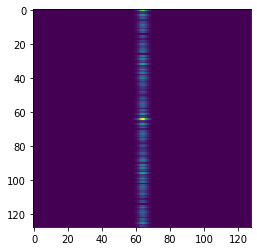

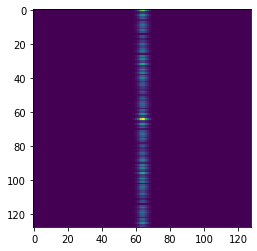

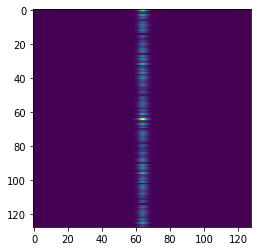

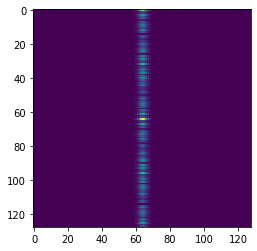

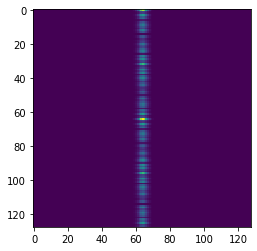

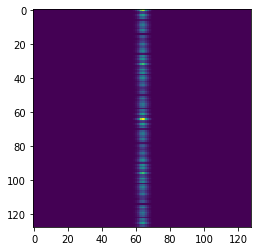

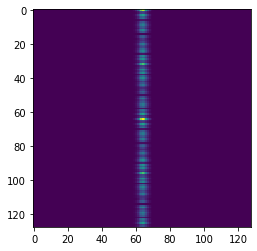

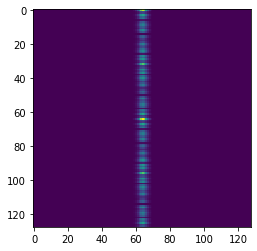

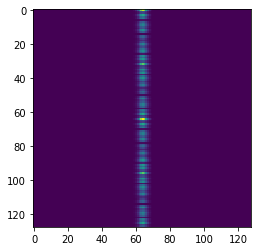

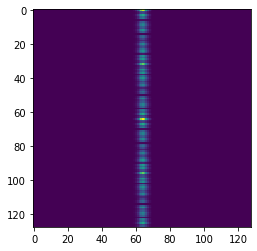

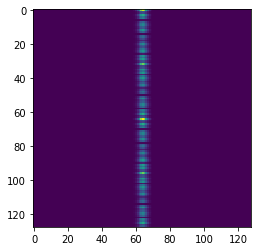

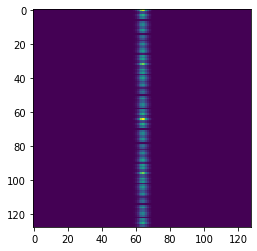

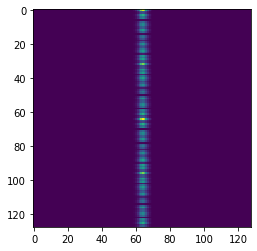

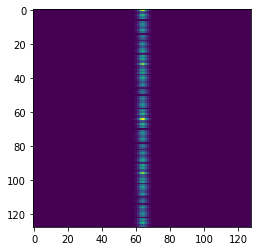

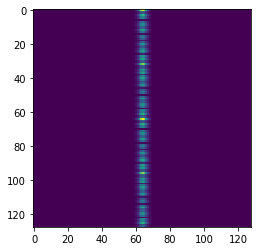

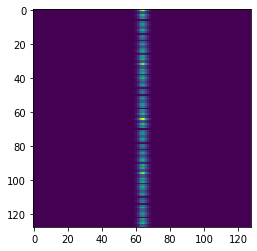

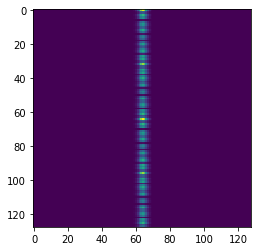

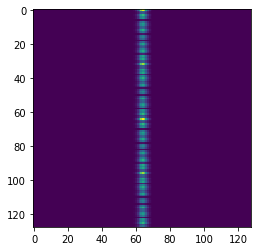

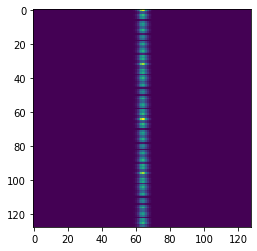

In [ ]:
for i in range(65):
    plt.imshow(np.abs(np.fft.ifftshift(np.fft.ifft2(batch['psf_cfht'][...,i,0]))))
    plt.show()